# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# Data pre-processing

## Exploratory Data Analysis (EDA)

In this section, I begin by familiarizing myself with the dataset. I use basic exploratory methods such as `pd.info()`
 to examine the data types of each column and identify the number of missing values.

In [11]:
# Load the data in CSV format
df = pd.read_csv('datensatz.csv')

# Visually inspect the data --> GH_PREIS = Getränke Hoffmann Preis
df.tail()

,WETTBEWERBER,ARTIKELNUMMER,ARTIKELNAME,KATEGORIE,GEBINDE,VERPACKUNG,LITERPREIS_WETTBEWERB,WETTBEWERBSPREIS,GH_PREIS
2598,WETTBEWERBER_2,19923806,Glenmorangie Highland Single Malt Scotch Whis,Spirituosen,"0,70l",FLASCHE,"1 l = 49,99 €",34.99,45.99
2599,WETTBEWERBER_2,19923806,Glenmorangie Highland Single Malt Scotch Whis,Spirituosen,"0,70l",FLASCHE,"1 l = 49,99 €",34.99,45.89
2600,WETTBEWERBER_2,18119954,Cocktail Plant by Vaihinger Piña Colada,Spirituosen,"0,25l",DOSE,"1 l = 11,56 €",2.89,2.69
2601,WETTBEWERBER_3,15384754,"Canonita Aperitivo de Naranjas 0,75l",Spirituosen,"0,75l",FLASCHE,"1 l = 22,65 €",16.99,18.09
2602,WETTBEWERBER_2,15384754,"Canonita Aperitivo de Naranjas 0,75l",Spirituosen,"0,75l",FLASCHE,"1 l = 22,65 €",16.99,17.99


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WETTBEWERBER           2603 non-null   object 
 1   ARTIKELNUMMER          2603 non-null   int64  
 2   ARTIKELNAME            2603 non-null   object 
 3   KATEGORIE              2593 non-null   object 
 4   GEBINDE                2598 non-null   object 
 5   VERPACKUNG             2591 non-null   object 
 6   LITERPREIS_WETTBEWERB  2330 non-null   object 
 7   WETTBEWERBSPREIS       2432 non-null   float64
 8   GH_PREIS               2593 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 183.2+ KB


- Columns without NaN-values: WETTBEWERBER, ARTIKELNUMMER, ARTIKELNAME
- Column with highets number of NaN-Values: WETTBEWERBSPREIS

As a pricing data analyst, these two columns, namely WETTBEWERBSPREIS and GH_PREIS are important. Therefore, they need to be imputated.

In [31]:
# Check top competitors for each drink category
df.groupby('KATEGORIE')['WETTBEWERBER'].describe()

,count,unique,top,freq
KATEGORIE,,,,
Bier & Biermischgetränke,802,3,WETTBEWERBER_2,354
Soft Drinks,1006,3,WETTBEWERBER_2,349
Spirituosen,247,3,WETTBEWERBER_3,85
Wasser,538,3,WETTBEWERBER_2,200


WETTBEWERBER_2 is the most common data source across most categories, except for Spirituosen, where WETTBEWERBER_3 is dominant.

## Data Wrangling

### Data Cleaning Overview

Some of the problems identified in the dataset include:

- **Standardized values in the `GEBINDE` column**:  
  Units like `"ml"` need to be converted to `"l"` for consistency. This involves parsing the values and converting milliliters to liters. Then, to find the total volumes in cases like `6x0,33l` the amounts are multiplied.

- **Missing values**, especially in the `LITERPREIS_WETTBEWERB` column:  
  These are imputed using related columns such as `WETTBEWERBSPREIS` and the parsed volume from `GEBINDE`.

- **Liter price of GH for each item**:  
  These are imputed using related columns such as `GH_PREIS` and the parsed volume from `GEBINDE`.

- **Duplicate rows**:  
  These are dropped, keeping only the first occurrence to ensure data integrity.


### Functions

In [12]:

def StandardizeUnits (gebinde):
    """
    Convert the ml unit to standard l units --> '6x355ml' to a string as 6x0,355l.
    Only changes when 'ml' is present.
    
    """
    if pd.isna(gebinde):
        return gebinde
    match = re.search(r'(\d+)ml', gebinde)
    if match:
        ml_val = int(match.group(1)) 
        liter_val = ml_val / 1000
        liter_string =  str(liter_val).replace ('.', ',') + 'l'

        return gebinde.replace(match.group(0), liter_string)
    return gebinde


def ParseVolume(gebinde):
    """
    Convert '6x1l' or '6x4x0,33l' to a float representing total volume in liters.
    Returns np.nan if input is NaN or parsing fails.
    
    """   
    if not pd.isna(gebinde):
        try:
            gebinde_decimal_checked= gebinde.replace(',', '.') # 0,33 --> 0.33
            gebinde_parts = re.findall(r'[\d.]+', gebinde_decimal_checked) # Only digits in a list e.g., ['6', '4', '0.33']
            volumes = [float(p) for p in gebinde_parts] # Change the data type to float for math cals
            return np.prod(volumes) # Take the multiplication of all the numbers in the list/array volumes
        except:
            return np.nan
    return np.nan


def LiterPrice(row, price_column):
    """
    Compute the price per liter for a single row (to find price per litre based on GH_PREIS).
    
    Args:
        row: a row from the DataFrame.
        price_column: the name of the column containing the total price.
        
    Returns:
        float: total price divided by total volume in liters.
    """
    totalprice = row[price_column]
    volume = ParseVolume(row['GEBINDE_STAND'])

    if not pd.isna(totalprice) and not pd.isna(volume) and volume != 0:
        return round(totalprice / volume, 2)
    return np.nan


In [6]:
# Sanity check calculations in the StandardizeUnits ,ParsePrice, and ParseVolume functions

su = StandardizeUnits('6x355ml')         # should return 6x0,355l
pp = ParsePrice('1 l = 1,13 €')        # should return 1.13
pv= ParseVolume('6x1l')               # should return 6.0
print(f' standardized units is: {su}, parsed price is: {pp} and parsed colume is {pv}')

 standardized units is: 6x0,355l, parsed price is: 1.13 and parsed colume is 6.0


### Standardization of units (GEBINDE column) 

In [13]:
# First, standardize the data by changing ml to l
df['GEBINDE_STAND'] = df['GEBINDE'].apply(StandardizeUnits)

In [14]:
# There are only two cases in the df with incorrect decimal (comparing the article name with article GEBINDE)

df['GEBINDE_STAND'] = df['GEBINDE_STAND'].replace({'6x275l': '6x0,275l', '275l': '0,275l'})

### Missing values

In [6]:
# Before filling the missing values
df_null = df.isnull().sum()
df_missing_values = df_null.to_frame(name = 'missing values')
df_missing_values['missing vallues %'] = (df.isnull().sum() / len(df) * 100)
df_missing_values

,missing values,missing vallues %
WETTBEWERBER,0,0.000000
ARTIKELNUMMER,0,0.000000
ARTIKELNAME,0,0.000000
KATEGORIE,10,0.384172
GEBINDE,5,0.192086
VERPACKUNG,12,0.461007
LITERPREIS_WETTBEWERB,273,10.487899
WETTBEWERBSPREIS,171,6.569343
GH_PREIS,10,0.384172
GEBINDE_STAND,5,0.192086


#### What is important for us is the missing values in LITERPREIS_WETTBEWERB (273 missing values). By using GEBINDE and WETTBEWERBSPREIS, it is possible to impute the missing values in this column. 

### Fill Up the Missing Values in LITERPREIS_WETTBEWERB Column

In [15]:
# Calculate the liter price for Wetbewerberb prices by LiterPrice function
df['LIETRPREIS_WB']= df.apply(LiterPrice, axis = 1, price_column= 'WETTBEWERBSPREIS')

In [8]:
# After filling the missing values
df_null = df.isnull().sum()
df_missing_values = df_null.to_frame(name = 'missing values')
df_missing_values['missing vallues %'] = (df.isnull().sum() / len(df) * 100)
df_missing_values

,missing values,missing vallues %
WETTBEWERBER,0,0.000000
ARTIKELNUMMER,0,0.000000
ARTIKELNAME,0,0.000000
KATEGORIE,10,0.384172
GEBINDE,5,0.192086
VERPACKUNG,12,0.461007
LITERPREIS_WETTBEWERB,273,10.487899
WETTBEWERBSPREIS,171,6.569343
GH_PREIS,10,0.384172
GEBINDE_STAND,5,0.192086


#### LITERPREIS_WETTBEWERB's missing values have dropped to 179 from 273 (65% improvement).

### Get the price per liter for GH prices

In [19]:

# Calculate the liter price for GH prices by LiterPrice function
df['LIETRPREIS_GH']= df.apply(LiterPrice, axis = 1, price_column= 'GH_PREIS')


In [20]:
df.describe()

,ARTIKELNUMMER,WETTBEWERBSPREIS,GH_PREIS,LIETRPREIS_WB,LIETRPREIS_GH
count,2.603000e+03,2432.000000,2593.000000,2424.000000,2585.000000
mean,1.010816e+07,4.724137,5.263598,4.133020,4.636673
std,6.847524e+06,6.271901,6.663316,7.389218,7.920108
min,3.491200e+04,0.390000,0.390000,0.090000,0.100000
25%,2.672833e+06,1.050000,1.290000,1.330000,1.490000
50%,1.312327e+07,1.690000,1.890000,2.180000,2.470000
75%,1.633714e+07,6.490000,7.190000,3.000000,3.610000
max,1.999836e+07,84.990000,74.490000,121.410000,106.410000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WETTBEWERBER           2603 non-null   object 
 1   ARTIKELNUMMER          2603 non-null   int64  
 2   ARTIKELNAME            2603 non-null   object 
 3   KATEGORIE              2593 non-null   object 
 4   GEBINDE                2598 non-null   object 
 5   VERPACKUNG             2591 non-null   object 
 6   LITERPREIS_WETTBEWERB  2330 non-null   object 
 7   WETTBEWERBSPREIS       2432 non-null   float64
 8   GH_PREIS               2593 non-null   float64
 9   GEBINDE_STAND          2598 non-null   object 
 10  LIETRPREIS_WB          2424 non-null   float64
 11  LIETRPREIS_GH          2585 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 244.2+ KB


### Duplicates

In [22]:
columns= ['WETTBEWERBER', 'ARTIKELNUMMER', 'ARTIKELNAME', 'KATEGORIE', 'GEBINDE',
       'VERPACKUNG', 'LITERPREIS_WETTBEWERB', 'GH_PREIS',
       'LIETRPREIS_WB', 'LIETRPREIS_GH']
# Find the duplicates in df based on the all columns (except for original WETTBEWERBSPREIS)
dup = df[df.duplicated(subset= columns, keep = False)]

In [25]:
dup

,WETTBEWERBER,ARTIKELNUMMER,ARTIKELNAME,KATEGORIE,GEBINDE,VERPACKUNG,LITERPREIS_WETTBEWERB,WETTBEWERBSPREIS,GH_PREIS,GEBINDE_STAND,LIETRPREIS_WB,LIETRPREIS_GH
74,WETTBEWERBER_1,15215678,Red Bull Energy Drink Pink Edition Waldbeere,Soft Drinks,"0,25l",DOSE,"1 l = 5,56 €",1.39,1.69,"0,25l",5.56,6.76
85,WETTBEWERBER_1,15215678,Red Bull Energy Drink Pink Edition Waldbeere,Soft Drinks,"0,25l",DOSE,"1 l = 5,56 €",1.39,1.69,"0,25l",5.56,6.76
152,WETTBEWERBER_3,15599640,"San Pellegrino Naturali Limonata 0,33l",Soft Drinks,"0,33l",DOSE,"1 l = 3,61 €",1.19,1.29,"0,33l",3.61,3.91
153,WETTBEWERBER_3,15599640,"San Pellegrino Naturali Limonata 0,33l",Soft Drinks,"0,33l",DOSE,"1 l = 3,61 €",1.19,1.29,"0,33l",3.61,3.91
917,WETTBEWERBER_3,18055514,"Vilsa H2Obst Apfel-Quitte-Zitrone 0,75l",Wasser,"0,75l",FLASCHE,"1 l = 1,59 €",1.19,1.29,"0,75l",1.59,1.72
918,WETTBEWERBER_3,18055514,"Vilsa H2Obst Apfel-Quitte-Zitrone 0,75l",Wasser,"0,75l",FLASCHE,"1 l = 1,59 €",1.19,1.29,"0,75l",1.59,1.72
1417,WETTBEWERBER_2,15572746,"Vitavate Pfirsich 0,5l",Wasser,"0,50l",FLASCHE,"1 l = 2,38 €",1.19,1.19,"0,50l",2.38,2.38
1418,WETTBEWERBER_2,15572746,"Vitavate Pfirsich 0,5l",Wasser,"0,50l",FLASCHE,"1 l = 2,38 €",1.19,1.19,"0,50l",2.38,2.38
2128,WETTBEWERBER_3,17423784,"Corona Extra 20x0,35l",Bier & Biermischgetränke,20x355ml,KASTEN,"1 l = 2,96 €",20.99,22.49,"20x0,355l",2.96,3.17
2129,WETTBEWERBER_3,17423784,"Corona Extra 20x0,35l",Bier & Biermischgetränke,20x355ml,KASTEN,"1 l = 2,96 €",20.99,22.49,"20x0,355l",2.96,3.17


#### There are 16 rows with duplicated values across all columns. These columns might negatively affect our results. So, they could be dropped.

In [26]:
# Dropping the missing values but keeping the first incidence
# Making a new df for only the unique (aka not duplicated) values

udf = df.drop_duplicates(keep = 'first', ignore_index = True)

In [27]:
udf

,WETTBEWERBER,ARTIKELNUMMER,ARTIKELNAME,KATEGORIE,GEBINDE,VERPACKUNG,LITERPREIS_WETTBEWERB,WETTBEWERBSPREIS,GH_PREIS,GEBINDE_STAND,LIETRPREIS_WB,LIETRPREIS_GH
0,WETTBEWERBER_3,951894,"Active O2 Apfel-Kiwi 0,75l",Wasser,"0,75l",FLASCHE,"1 l = 1,59 €",1.19,1.19,"0,75l",1.59,1.59
1,WETTBEWERBER_2,951894,"Active O2 Apfel-Kiwi 0,75l",Wasser,"0,75l",FLASCHE,"1 l = 1,59 €",1.19,1.29,"0,75l",1.59,1.72
2,WETTBEWERBER_1,951894,"Active O2 Apfel-Kiwi 0,75l",Wasser,"0,75l",FLASCHE,"1 l = 1,59 €",1.19,1.59,"0,75l",1.59,2.12
3,WETTBEWERBER_3,951910,"Active O2 Cherry 0,75l",Wasser,"0,75l",FLASCHE,"1 l = 1,59 €",1.19,1.39,"0,75l",1.59,1.85
4,WETTBEWERBER_2,951910,"Active O2 Cherry 0,75l",Wasser,"0,75l",FLASCHE,"1 l = 1,59 €",1.19,1.29,"0,75l",1.59,1.72
...,...,...,...,...,...,...,...,...,...,...,...,...
2590,WETTBEWERBER_2,19923806,Glenmorangie Highland Single Malt Scotch Whis,Spirituosen,"0,70l",FLASCHE,"1 l = 49,99 €",34.99,45.99,"0,70l",49.99,65.70
2591,WETTBEWERBER_2,19923806,Glenmorangie Highland Single Malt Scotch Whis,Spirituosen,"0,70l",FLASCHE,"1 l = 49,99 €",34.99,45.89,"0,70l",49.99,65.56
2592,WETTBEWERBER_2,18119954,Cocktail Plant by Vaihinger Piña Colada,Spirituosen,"0,25l",DOSE,"1 l = 11,56 €",2.89,2.69,"0,25l",11.56,10.76
2593,WETTBEWERBER_3,15384754,"Canonita Aperitivo de Naranjas 0,75l",Spirituosen,"0,75l",FLASCHE,"1 l = 22,65 €",16.99,18.09,"0,75l",22.65,24.12


In [28]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595 entries, 0 to 2594
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WETTBEWERBER           2595 non-null   object 
 1   ARTIKELNUMMER          2595 non-null   int64  
 2   ARTIKELNAME            2595 non-null   object 
 3   KATEGORIE              2585 non-null   object 
 4   GEBINDE                2590 non-null   object 
 5   VERPACKUNG             2583 non-null   object 
 6   LITERPREIS_WETTBEWERB  2322 non-null   object 
 7   WETTBEWERBSPREIS       2424 non-null   float64
 8   GH_PREIS               2585 non-null   float64
 9   GEBINDE_STAND          2590 non-null   object 
 10  LIETRPREIS_WB          2416 non-null   float64
 11  LIETRPREIS_GH          2577 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 243.4+ KB


### Statistical summary

In [29]:
udf.describe()

,ARTIKELNUMMER,WETTBEWERBSPREIS,GH_PREIS,LIETRPREIS_WB,LIETRPREIS_GH
count,2.595000e+03,2424.000000,2585.000000,2416.000000,2577.000000
mean,1.009409e+07,4.716988,5.256940,4.122508,4.626411
std,6.848149e+06,6.265883,6.657307,7.386902,7.918015
min,3.491200e+04,0.390000,0.390000,0.090000,0.100000
25%,2.669162e+06,1.050000,1.290000,1.330000,1.490000
50%,1.312308e+07,1.690000,1.890000,2.180000,2.440000
75%,1.633602e+07,6.490000,7.190000,3.000000,3.580000
max,1.999836e+07,84.990000,74.490000,121.410000,106.410000


### Summary of Statistical Analysis

Based on the descriptive statistics above, we can observe the following:

- The **average total price** for GH (`GH_PREIS`, mean: 5.26) is higher than that of the **competitor** (`WETTBEWERBSPREIS`, mean: 4.72), indicating that GH tends to price its products above the market average. This trend is consistent across both total price and price per liter.

- Although the **maximum value** for `WETTBEWERBSPREIS` (84.99) slightly exceeds that of `GH_PREIS` (74.49), the overall **distribution** shows that GH has higher prices at most percentiles, including the 25th, 50th, and 75th percentiles.

- The **standard deviations** of `GH_PREIS` (6.66) and `WETTBEWERBSPREIS` (6.27) are similar, suggesting comparable variability and price dispersion across both groups. This also implies the possible presence of similarly skewed distributions (likely right-skewed, given the large max values relative to the medians).

- When analyzing **price per liter**, the same pattern holds:
  - `LIETRPREIS_GH` (mean: 4.63 €/L) is higher than `LIETRPREIS_WB` (mean: 4.12 €/L)
  - with similar standard deviations (7.92 vs. 7.39), indicating consistent pricing strategies in terms of product volume.

- **Median (50th percentile) values** also reinforce these patterns:
  - `GH_PREIS`: 1.89  
  - `WETTBEWERBSPREIS`: 1.69  
  - `LIETRPREIS_GH`: 2.44 €/L  
  - `LIETRPREIS_WB`: 2.18 €/L  
  This suggests that while GH prices are slightly higher across the board, the difference is more pronounced in the **upper range** (i.e., 75th percentile and max values), where the price gaps widen.

- Notably, **extreme values** (e.g., per-liter prices of up to 121.41 €/L for competitors and 106.41 €/L for GH) likely correspond to small-volume or premium items, contributing to the large spread in both datasets.



### Save the cleaned df

After imputing missing values and removing duplicates, we can optionally save the resulting dataset as a `unique DataFrame`
. It's worth noting that outlier detection and handling could have also been addressed at this stage. However, to maintain a logical flow aligned with the task requirements, I chose to perform the outlier analysis in the following section.

In [ ]:
udf.to_csv("SalesEdited.csv", index=False)

### Summary

In the cells above, I performed data cleaning steps to prepare the dataset for further analysis:

- Standardized the `GEBINDE` column by converting units from milliliters to liters and check for inconsistancies.
- calculated the price per liter for `GH_PREIS` column.
- Imputed missing values in the `LITERPREIS_WETTBEWERB` column using the available total price and product volume.
- Removed duplicate rows to ensure data consistency and accuracy.

These preprocessing steps ensure that the dataset is more reliable and ready for downstream tasks such as visualization, or business decision-making


# Task 1

## 1 - Wie ist ganz grundsätzlich unsere Preispositionierung? In welchen Preisregionen bewegen wir uns mit unseren Preisen?
"How is our general price positioning? In which price regions are we operating?"

In [4]:
# Load the dataset
df = pd.read_csv('SalesEdited.csv')

### Price Distribution (1): Box Plot

/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_31106/229847491.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gh_preis, wettbewerbspreis], labels=['GH €/L', 'WETTBEWERBER €/L'])


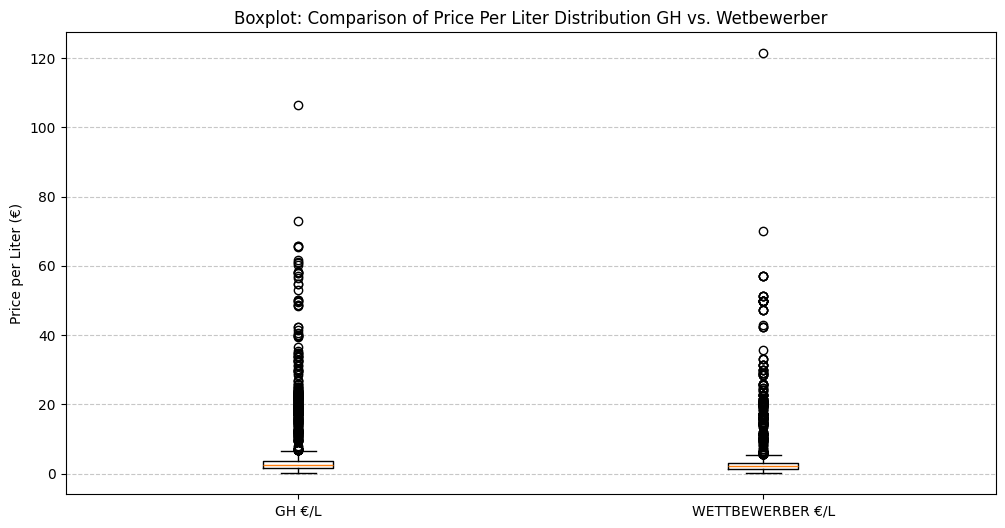

In [78]:
# Drop missing values
gh_preis = df['LIETRPREIS_GH'].dropna()
wettbewerbspreis = df['LIETRPREIS_WB'].dropna()

plt.figure(figsize=(12, 6))

# Boxplot
plt.boxplot([gh_preis, wettbewerbspreis], labels=['GH €/L', 'WETTBEWERBER €/L'])
plt.title('Boxplot: Comparison of Price Per Liter Distribution GH vs. Wetbewerber')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel ('Price per Liter (€)')
plt.savefig('BoxPlot.png', dpi= 300, format= 'png')
plt.show()


- Central Tendency (Median): The thick horizontal line inside each box represents the median (50th percentile) price. Both GH and Wettbewerber have similar medians, suggesting that at the middle of the distribution, prices are not drastically different.
- Spread (IQR – Interquartile Range): The height of each box shows the range between the 25th percentile (Q1) and 75th percentile (Q3). The spread appears to be similar in both, indicating that the majority of products fall within a similar price range for both groups.
- Outliers: The black circles above the whiskers are outliers – products priced significantly higher than the rest. Both GH and Wettbewerb show a large number of high outliers, but: Wettbewerb has a slightly taller maximum outlier (around €120 vs. €110 for GH). Both show a long tail of high-priced items, which could include premium or niche products.
- Conclusion: Most prices are similar between GH and competitors. GH is not drastically more expensive, on average, based on this visual. However, both retailers and competitors carry expensive outliers, possibly reflecting luxury or specialty products.


### Price Distribution (2): Histogram

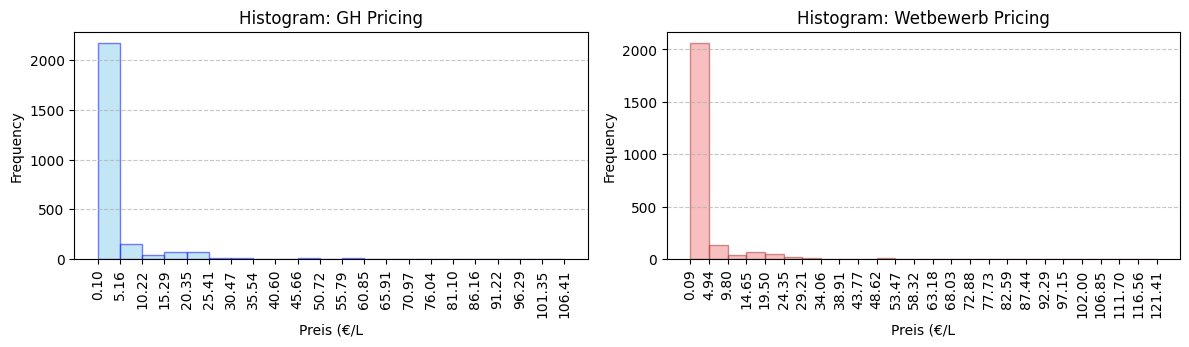

In [43]:
# Drop missing values
gh_preis = df['LIETRPREIS_GH'].dropna()
wettbewerbspreis = df['LIETRPREIS_WB'].dropna()

plt.figure(figsize=(12, 6))

# Histogram Comparison (1st)
plt.subplot(2, 2, 1)

# Create histogram and get bin edges
counts, bins, patches = plt.hist(gh_preis, bins=21, alpha= 0.5, color='skyblue', edgecolor='blue')

# Set xticks to bin centers
plt.xticks(bins, labels=[f"{x:.2f}" for x in bins], rotation=90)

# Set labels and titles for the 1st plot (on the left)
plt.xlabel("Preis (€/L")
plt.ylabel("Frequency")
plt.title("Histogram: GH Pricing")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Histogram Comparison (2st)
plt.subplot(2, 2, 2)

# Create histogram and get bin edges
counts, bins, patches = plt.hist(wettbewerbspreis, bins=25, alpha= 0.5, color='lightcoral', edgecolor='brown')

# Set xticks to bin centers
plt.xticks(bins, labels=[f"{x:.2f}" for x in bins], rotation=90)

# Set labels and titles for thr 2nd plot (on the right)
plt.xlabel("Preis (€/L")
plt.ylabel("Frequency")
plt.title("Histogram: Wetbewerb Pricing")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set the layout and save the figure
plt.tight_layout()
plt.savefig('Hist.png', dpi= 300, format= 'png')

plt.show()


### Price Distribution (3): Kernal Density Estimate (KDE)

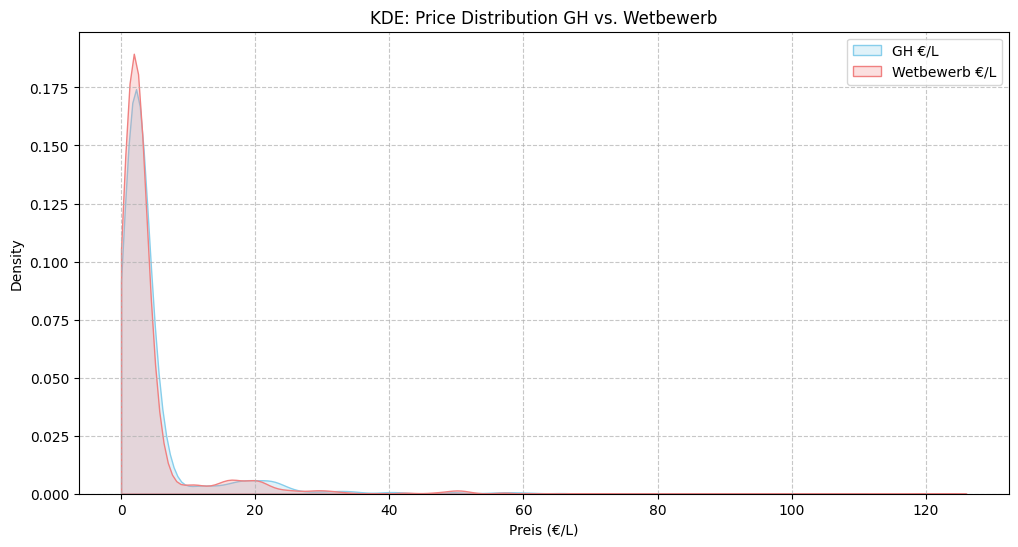

In [44]:
# Drop missing values
gh_preis = df['LIETRPREIS_GH'].dropna()
wettbewerbspreis = df['LIETRPREIS_WB'].dropna()

plt.figure(figsize=(12, 6))

# Create a 2 KDE graphs alligned onto eachother
# 1st
sns.kdeplot(gh_preis, label='GH €/L', fill=True, color='skyblue',  clip=(0, None))
# 2nd
sns.kdeplot(wettbewerbspreis, label='Wetbewerb €/L', fill=True, color='lightcoral', clip=(0, None))

# Set the overal look of the plot
plt.title('KDE: Price Distribution GH vs. Wetbewerb')
plt.xlabel('Preis (€/L)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Save the figure
plt.savefig('KDE.png', dpi= 300, format= 'png')

plt.show()


## 2- Wie viele Artikel sind günstiger, gleich teuer oder teurer als der Wettbewerb? Wie ist der Preisabstand zum Wettbewerb?

### 2.1) Anzahl der günstigeren, gleich teuren und teureren Artikel.

In [4]:
"""
There are duplications in article numbers with variations in their prices per liter for Getränke Hoffmann and Wetbewerber.
To avoid any duplications and bias, the dataset is grouped by articke numbers and their avrage prices are calculated for both GH-Price 
and Wetbewerber-Price.
"""

GroupByArticleNumbber = df.groupby(['ARTIKELNUMMER', 'KATEGORIE']) [['LIETRPREIS_GH', 'LIETRPREIS_WB']].mean()
GroupByArticleNumbber.rename(columns={
    'LIETRPREIS_GH': 'avg. LIETRPREIS_GH',
    'LIETRPREIS_WB': 'avg. LIETRPREIS_WB'
}, inplace=True)

GroupByArticleNumbber

,,avg. LIETRPREIS_GH,avg. LIETRPREIS_WB
ARTIKELNUMMER,KATEGORIE,,
34912,Bier & Biermischgetränke,2.780000,2.180000
34918,Bier & Biermischgetränke,2.513333,2.180000
34940,Bier & Biermischgetränke,2.446667,1.833333
34960,Bier & Biermischgetränke,2.180000,9.780000
34994,Bier & Biermischgetränke,2.080000,1.700000
...,...,...,...
19923806,Spirituosen,65.700000,49.990000
19958676,Soft Drinks,3.910000,4.210000
19994368,Soft Drinks,2.713333,2.780000


In [5]:
GroupByArticleNumbber.dropna(inplace= True)

In [6]:
# Sum of the number of articles whose price is lower than competitors'
cheaper_count = (GroupByArticleNumbber['avg. LIETRPREIS_GH'] < GroupByArticleNumbber['avg. LIETRPREIS_WB']).sum() 

# Sum of the number of articles whose price is equal to competitors'
equal_count = (GroupByArticleNumbber['avg. LIETRPREIS_GH'] == GroupByArticleNumbber['avg. LIETRPREIS_WB']).sum()

# Sum of the number of articles whose price is higher than competitors'
more_expensive_count = (GroupByArticleNumbber['avg. LIETRPREIS_GH'] > GroupByArticleNumbber['avg. LIETRPREIS_WB']).sum()

# Print the results
print(f"Cheaper products: {cheaper_count}")
print(f"Equal price products: {equal_count}")
print(f"More expensive products: {more_expensive_count}")

Cheaper products: 150
Equal price products: 76
More expensive products: 1181


#### On average, most of the items have higher prices comparing to the competitors (1181 articles). Moreover, there are 150 articles which are priced lower than the competitors and 76 items are priced equally.  

In [76]:
# Label the pricing by comparing GH-Price and Wettbewerber Pricing

GroupByArticleNumbber['price_comparison'] = np.where(
    GroupByArticleNumbber['avg. LIETRPREIS_WB'] > GroupByArticleNumbber['avg. LIETRPREIS_GH'],
    'GH Cheaper',
    np.where(
        GroupByArticleNumbber['avg. LIETRPREIS_WB']< GroupByArticleNumbber['avg. LIETRPREIS_GH'],
        'GH Expensive',
        'Prices Equal'
    )
)


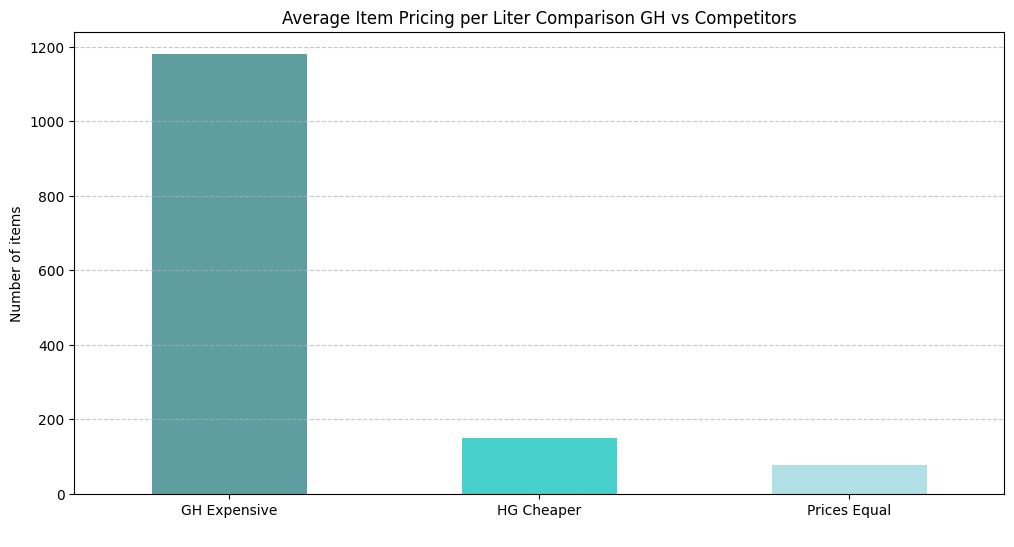

In [8]:
# Plot the number of articles which are cheaper, more expensive and same priced.
plt.figure(figsize=(12, 6))

GroupByArticleNumbber['price_comparison'].value_counts().plot(kind='bar', color=['cadetblue', 'mediumturquoise', 'powderblue'], label = 'WETTBEWERBER')
plt.title("Average Item Pricing per Liter Comparison GH vs Competitors")
plt.ylabel("Number of items")
plt.xlabel(" ")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('bar_compare.png', dpi= 300, format = 'png')
plt.show()


## 3- In welchen Produktgruppen sind wir im Durchschnitt besonders wettbewerbsfähig oder auffällig teuer?

In [65]:
# See the mean price per liter of items in each category  for GH pricing

MeanPriceEachCategoryGH = GroupByArticleNumbber.groupby('KATEGORIE') ['avg. LIETRPREIS_GH'].mean()
MeanPriceEachCategoryGH

KATEGORIE
Bier & Biermischgetränke     2.892169
Soft Drinks                  2.965691
Spirituosen                 23.985698
Wasser                       1.222190
Name: avg. LIETRPREIS_GH, dtype: float64

In [66]:
# See the mean price per liter of items in each category for WB pricing

MeanPriceEachCategoryWB = GroupByArticleNumbber.groupby('KATEGORIE') ['avg. LIETRPREIS_WB'].mean()
MeanPriceEachCategoryWB

KATEGORIE
Bier & Biermischgetränke     2.618507
Soft Drinks                  2.597088
Spirituosen                 22.365736
Wasser                       1.073350
Name: avg. LIETRPREIS_WB, dtype: float64

In [12]:
# Group by category and price comparison and count occurrences
GroupByKategorie = GroupByArticleNumbber.groupby(['KATEGORIE', 'price_comparison']).size().unstack(fill_value=0)

GroupByKategorie ['Total'] = GroupByKategorie.sum(axis= 1)
GroupByKategorie

price_comparison,GH Expensive,HG Cheaper,Prices Equal,Total
KATEGORIE,,,,
Bier & Biermischgetränke,418,53,27,498
Soft Drinks,422,51,29,502
Spirituosen,92,16,3,111
Wasser,249,30,17,296


In [13]:
# Select only the columns with counts (exclude 'Total')
Cols = ['GH Expensive', 'HG Cheaper', 'Prices Equal']

# Calculate percentages by dividing counts by 'Total'
PercentCategory = GroupByKategorie[Cols].div(GroupByKategorie['Total'], axis=0) * 100

# Round to 2 decimals
PercentCategory = PercentCategory.round(2)
PercentCategory = PercentCategory.astype(str) + "%"

# percent_df now has the same index and columns but with percentage values
PercentCategory


price_comparison,GH Expensive,HG Cheaper,Prices Equal
KATEGORIE,,,
Bier & Biermischgetränke,83.94%,10.64%,5.42%
Soft Drinks,84.06%,10.16%,5.78%
Spirituosen,82.88%,14.41%,2.7%
Wasser,84.12%,10.14%,5.74%


**Overall Trend:** 

Across all categories, more than **80%** of products are more expensive at GH compared to competitors. This suggests that GH's pricing strategy is consistently higher across all categories.

_Cheapest Category for GH:_
In the Spirituosen (spirits) category, GH is cheaper than competitors 14.41% of the time — slightly better than in other categories. However, GH is still more expensive in over 82% of cases.

_Equal Pricing:_
The proportion of identical prices ranges from 2.7% (Spirituosen) to 5.78% (Soft Drinks), indicating that price matching is rare.


<Figure size 1200x600 with 0 Axes>

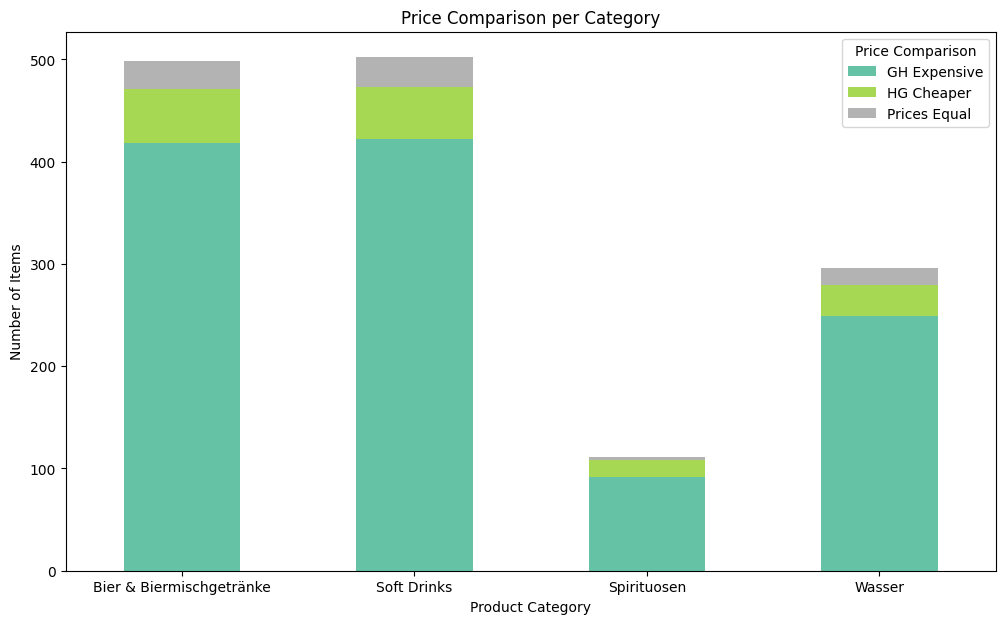

In [16]:
# Visualise the price comparison across all categories
plt.figure(figsize=(12, 6))

GroupByKategorieToPlot = GroupByKategorie[Cols]
GroupByKategorieToPlot.plot(kind='bar', stacked=True, figsize=(12,7), colormap='Set2')
plt.xticks(rotation=0)
plt.title('Price Comparison per Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Items')
plt.legend(title='Price Comparison')

# Save the figure
plt.savefig('bar_price_compare.png', dpi= 300, format = 'png')
plt.show()


In [50]:
# Finding the price differences/price deviation in each item category  

GroupByArticleNumbber['price_diff'] = GroupByArticleNumbber['avg. LIETRPREIS_GH'] - GroupByArticleNumbber['avg. LIETRPREIS_WB']
avg_deviation = GroupByArticleNumbber.groupby('KATEGORIE')['price_diff'].mean().reset_index()
avg_deviation

,KATEGORIE,price_diff
0,Bier & Biermischgetränke,0.273661
1,Soft Drinks,0.368602
2,Spirituosen,1.619962
3,Wasser,0.148840


/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_31106/3656809675.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = mean_prices_sorted['KATEGORIE'], y = mean_prices_sorted['price_diff'],


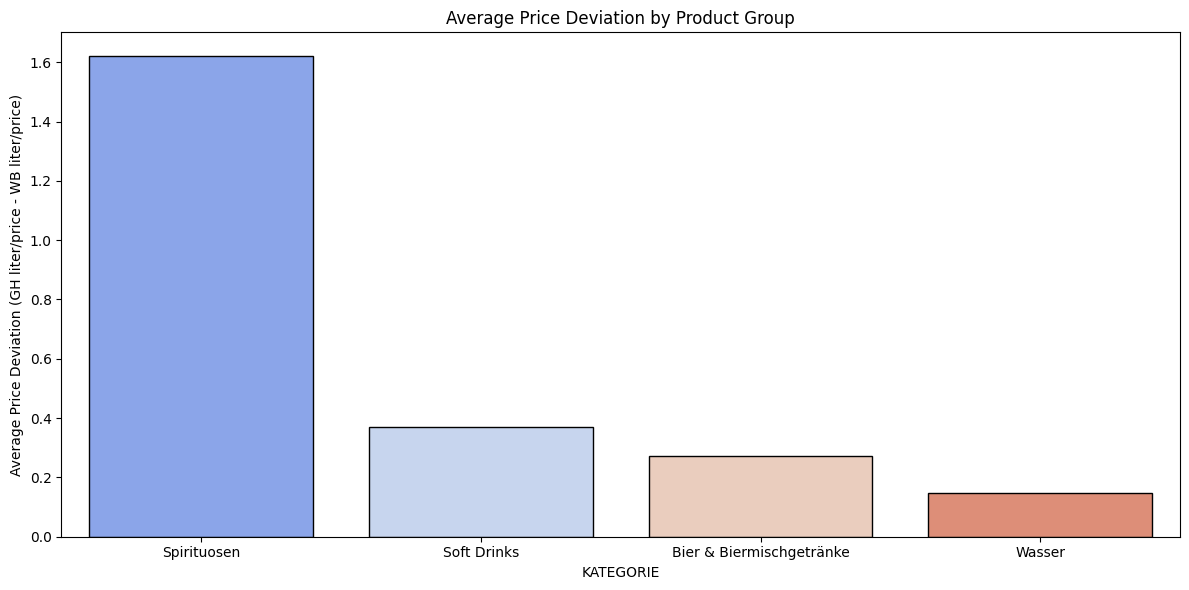

In [75]:
# Plot the price deviation for each group

# Sort by price difference to see where GH is most expensive or competitive
mean_prices_sorted = avg_deviation.sort_values(by="price_diff", ascending=False)

plt.figure(figsize=(12,6))

sns.barplot(x = mean_prices_sorted['KATEGORIE'], y = mean_prices_sorted['price_diff'], 
        palette="coolwarm", edgecolor="black")

plt.xticks(rotation=0, ha='center')
plt.ylabel('Average Price Deviation (GH liter/price - WB liter/price)')
plt.title('Average Price Deviation by Product Group')
plt.tight_layout()
plt.savefig('dev.png', dpi= 300, format = 'png')
plt.show()


#### Across all product categories, GH prices are on average higher than competitors. The price difference is most pronounced in 'Spirituosen', where GH charges approximately 1.62 €/L more. The category with the smallest difference is 'Wasser', suggesting this is where GH is relatively most competitive, although still slightly more expensive.

## Gibt es auffällige Ausreißer oder systematische Muster?

### The correlation between GH price and Wetbewerber

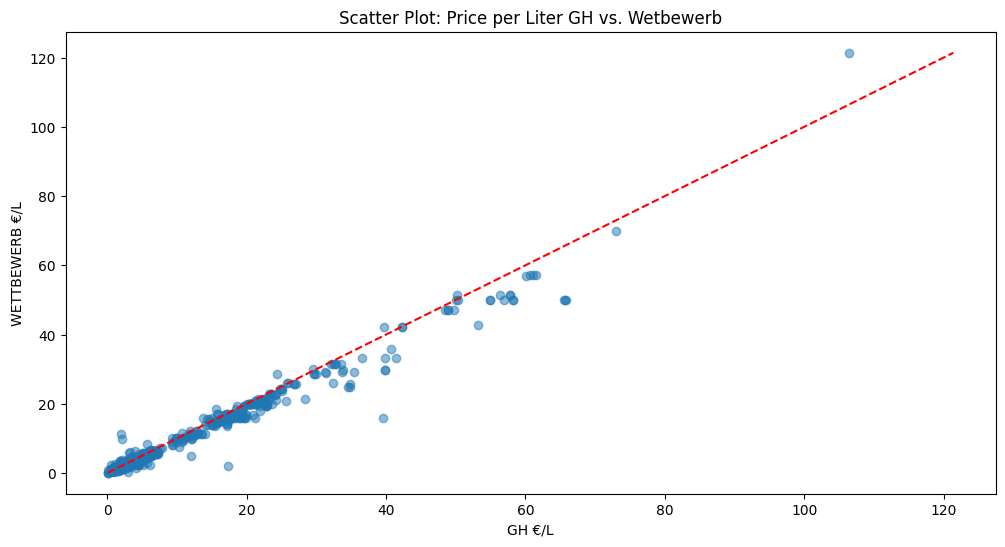

In [85]:

# Scatter plot: GH price vs competitor price
plt.figure(figsize=(12,6))
plt.scatter(df['LIETRPREIS_GH'], df['LIETRPREIS_WB'], alpha=0.5)
plt.xlabel('GH €/L')
plt.ylabel('WETTBEWERB €/L')
plt.title('Scatter Plot: Price per Liter GH vs. Wetbewerb')

# identity line
plt.plot([df['LIETRPREIS_GH'].min(), df['LIETRPREIS_WB'].max()],
         [df['LIETRPREIS_GH'].min(), df['LIETRPREIS_WB'].max()], 'r--')  

plt.savefig('scatter.png', dpi=300, format='png')
plt.show()


In [84]:
df_prices = df[['LIETRPREIS_GH', 'LIETRPREIS_WB']].dropna()
person_coeff, p_value = stats.pearsonr(df_prices['LIETRPREIS_GH'], df_prices['LIETRPREIS_WB'])
print(f'Pearson Coefficient: {person_coeff.round(2)} and p-value: {p_value}')

Pearson Coefficient: 0.99 and p-value: 0.0


#### Based on the scatter plot and the pearson coefficient, we can conclude that When competitor prices increase, GH prices increase nearly proportionally (and vice versa). Despite differences in individual products, overall pricing strategy closely mirrors market competitors. And according to p-value, we can confidently conclude that GH prices and competitor prices are strongly, positively correlated.

### Identifying outliers

In [19]:
def find_outliers(series):
    """
    Detects outliers in a given numerical pandas Series using the IQR (Interquartile Range) method.

    Parameters:
    -----------
    series : pd.Series
        A numerical column (e.g., price per liter) for which outliers are to be identified.

    Returns:
    --------
    pd.Series
        A subset of the input series containing only the values that are outliers.
        Outliers are defined as values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR.
    """

    # Calculate the first (Q1) and third (Q3) quartiles
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)

    # Calculate the interquartile range
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR # Whisker 1
    upper_bound = Q3 + 1.5 * IQR # Whisker 1

    # Return values that lie outside the lower and upper bounds (i.e., the outliers)
    return series[(series < lower_bound) | (series > upper_bound)]

df = df.dropna()
# Apply the function to detect outliers in GH price per liter
outliers_gh = find_outliers(df['LIETRPREIS_GH'])

# Apply the function to detect outliers in competitor price per liter
outliers_comp = find_outliers(df['LIETRPREIS_WB'])

# Print the number of detected outliers in each group
print(f'Number of GH price outliers: {len(outliers_gh)}')
print(f'Number of Competitor price outliers: {len(outliers_comp)}')



Number of GH price outliers: 248
Number of Competitor price outliers: 292


In [20]:
# Find the top 10 outliers in GH pricing

# Make a new df with the outliers of GH prices per liter 
OutliersGH= df.loc[outliers_gh.index, ['ARTIKELNAME', 'KATEGORIE', 'GEBINDE', 'VERPACKUNG', 'LIETRPREIS_WB', 'LIETRPREIS_GH']]

# Group the data based on category names to see only the unique items in the outliers top ten
OutlierGHGrouped = OutliersGH.groupby(['KATEGORIE', 'ARTIKELNAME'])['LIETRPREIS_GH'].describe().reset_index()
OutlierGHGroupedTop10= OutlierGHGrouped.sort_values(by='mean', ascending=False).head(10)

OutlierGHGroupedTop10

,KATEGORIE,ARTIKELNAME,count,mean,std,min,25%,50%,75%,max
115,Spirituosen,The Macallan Double Cask Highland Single Malt,1.0,106.410000,NaN,106.41,106.410,106.41,106.410,106.41
76,Spirituosen,"Knut Hansen Dry Gin 0,5l",1.0,72.980000,NaN,72.98,72.980,72.98,72.980,72.98
53,Spirituosen,Glenmorangie Highland Single Malt Scotch Whis,3.0,65.700000,0.140000,65.56,65.630,65.70,65.770,65.84
33,Spirituosen,"Butocal Reserva Exclusiva Rum 0,7l",3.0,61.130000,0.430000,60.70,60.915,61.13,61.345,61.56
112,Spirituosen,"Talisker Skye Single Malt Scotch Whisky 0,7l",1.0,60.130000,NaN,60.13,60.130,60.13,60.130,60.13
69,Spirituosen,"Jägermeister Manifest 0,5l",3.0,57.780000,0.692820,56.98,57.580,58.18,58.180,58.18
61,Spirituosen,"Hennessy V.S Cognac 0,7l",3.0,57.363333,0.825611,56.41,57.125,57.84,57.840,57.84
117,Spirituosen,Underberg 4x20ml,2.0,54.870000,0.000000,54.87,54.870,54.87,54.870,54.87
111,Spirituosen,"Suntory Toki Japanischer Blended Whisky 0,7l",1.0,53.130000,NaN,53.13,53.130,53.13,53.130,53.13
52,Spirituosen,"Glenfiddich 12 Years 0,7l",3.0,50.130000,0.140000,49.99,50.060,50.13,50.200,50.27


In [21]:
# Find the top 10 outliers in WB pricing

# Make a new df with the outliers of WB prices per liter 
OutlierWB= df.loc[outliers_comp.index, ['ARTIKELNAME', 'KATEGORIE', 'GEBINDE', 'VERPACKUNG', 'LIETRPREIS_WB', 'GH_PREIS']]

# Group the data based on category names to see only the unique items in the outliers top ten
OutlierWBGrouped = OutlierWB.groupby(['KATEGORIE', 'ARTIKELNAME'])['LIETRPREIS_WB'].describe().reset_index()
OutlierWBGroupedTop10 = OutlierWBGrouped.sort_values(by='mean', ascending=False).head(10)

OutlierWBGroupedTop10

,KATEGORIE,ARTIKELNAME,count,mean,std,min,25%,50%,75%,max
137,Spirituosen,The Macallan Double Cask Highland Single Malt,1.0,121.410000,NaN,121.41,121.41,121.41,121.41,121.41
98,Spirituosen,"Knut Hansen Dry Gin 0,5l",1.0,69.980000,NaN,69.98,69.98,69.98,69.98,69.98
55,Spirituosen,"Butocal Reserva Exclusiva Rum 0,7l",3.0,57.130000,0.000000,57.13,57.13,57.13,57.13,57.13
134,Spirituosen,"Talisker Skye Single Malt Scotch Whisky 0,7l",1.0,57.000000,NaN,57.00,57.00,57.00,57.00,57.00
83,Spirituosen,"Hennessy V.S Cognac 0,7l",3.0,51.410000,0.000000,51.41,51.41,51.41,51.41,51.41
74,Spirituosen,"Glenfiddich 12 Years 0,7l",3.0,50.463333,0.819837,49.99,49.99,49.99,50.70,51.41
75,Spirituosen,Glenmorangie Highland Single Malt Scotch Whis,3.0,49.990000,0.000000,49.99,49.99,49.99,49.99,49.99
91,Spirituosen,"Jägermeister Manifest 0,5l",3.0,49.980000,0.000000,49.98,49.98,49.98,49.98,49.98
139,Spirituosen,Underberg 4x20ml,2.0,49.880000,0.000000,49.88,49.88,49.88,49.88,49.88
82,Spirituosen,"Hendrick's Gin 0,7l",3.0,47.130000,0.000000,47.13,47.13,47.13,47.13,47.13


In [25]:
# Highlight the articles which are observed as outliers in both WB anf GH pricing
# To check if the outliers are just a normal variations in the dataset or problematic entries or errors

# set: only unique elements
common_values = set(OutlierGHGroupedTop10['ARTIKELNAME']).intersection(OutlierWBGroupedTop10['ARTIKELNAME'])

def highlight_common(val):
    if val in common_values:
        return 'background-color: lightgreen'
    return ''

OutlierGHGroupedTop10Highlighted = OutlierGHGroupedTop10.style.applymap(highlight_common, subset=['ARTIKELNAME'])
OutlierWBGroupedTop10Highlighted = OutlierWBGroupedTop10.style.applymap(highlight_common, subset=['ARTIKELNAME'])


/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_92577/4070741794.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  OutlierGHGroupedTop10Highlighted = OutlierGHGroupedTop10.style.applymap(highlight_common, subset=['ARTIKELNAME'])
/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_92577/4070741794.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  OutlierWBGroupedTop10Highlighted = OutlierWBGroupedTop10.style.applymap(highlight_common, subset=['ARTIKELNAME'])


In [26]:
OutlierGHGroupedTop10Highlighted

,KATEGORIE,ARTIKELNAME,count,mean,std,min,25%,50%,75%,max
115,Spirituosen,The Macallan Double Cask Highland Single Malt,1.000000,106.410000,nan,106.410000,106.410000,106.410000,106.410000,106.410000
76,Spirituosen,"Knut Hansen Dry Gin 0,5l",1.000000,72.980000,nan,72.980000,72.980000,72.980000,72.980000,72.980000
53,Spirituosen,Glenmorangie Highland Single Malt Scotch Whis,3.000000,65.700000,0.140000,65.560000,65.630000,65.700000,65.770000,65.840000
33,Spirituosen,"Butocal Reserva Exclusiva Rum 0,7l",3.000000,61.130000,0.430000,60.700000,60.915000,61.130000,61.345000,61.560000
112,Spirituosen,"Talisker Skye Single Malt Scotch Whisky 0,7l",1.000000,60.130000,nan,60.130000,60.130000,60.130000,60.130000,60.130000
69,Spirituosen,"Jägermeister Manifest 0,5l",3.000000,57.780000,0.692820,56.980000,57.580000,58.180000,58.180000,58.180000
61,Spirituosen,"Hennessy V.S Cognac 0,7l",3.000000,57.363333,0.825611,56.410000,57.125000,57.840000,57.840000,57.840000
117,Spirituosen,Underberg 4x20ml,2.000000,54.870000,0.000000,54.870000,54.870000,54.870000,54.870000,54.870000
111,Spirituosen,"Suntory Toki Japanischer Blended Whisky 0,7l",1.000000,53.130000,nan,53.130000,53.130000,53.130000,53.130000,53.130000
52,Spirituosen,"Glenfiddich 12 Years 0,7l",3.000000,50.130000,0.140000,49.990000,50.060000,50.130000,50.200000,50.270000


In [27]:
OutlierWBGroupedTop10Highlighted

,KATEGORIE,ARTIKELNAME,count,mean,std,min,25%,50%,75%,max
137,Spirituosen,The Macallan Double Cask Highland Single Malt,1.000000,121.410000,nan,121.410000,121.410000,121.410000,121.410000,121.410000
98,Spirituosen,"Knut Hansen Dry Gin 0,5l",1.000000,69.980000,nan,69.980000,69.980000,69.980000,69.980000,69.980000
55,Spirituosen,"Butocal Reserva Exclusiva Rum 0,7l",3.000000,57.130000,0.000000,57.130000,57.130000,57.130000,57.130000,57.130000
134,Spirituosen,"Talisker Skye Single Malt Scotch Whisky 0,7l",1.000000,57.000000,nan,57.000000,57.000000,57.000000,57.000000,57.000000
83,Spirituosen,"Hennessy V.S Cognac 0,7l",3.000000,51.410000,0.000000,51.410000,51.410000,51.410000,51.410000,51.410000
74,Spirituosen,"Glenfiddich 12 Years 0,7l",3.000000,50.463333,0.819837,49.990000,49.990000,49.990000,50.700000,51.410000
75,Spirituosen,Glenmorangie Highland Single Malt Scotch Whis,3.000000,49.990000,0.000000,49.990000,49.990000,49.990000,49.990000,49.990000
91,Spirituosen,"Jägermeister Manifest 0,5l",3.000000,49.980000,0.000000,49.980000,49.980000,49.980000,49.980000,49.980000
139,Spirituosen,Underberg 4x20ml,2.000000,49.880000,0.000000,49.880000,49.880000,49.880000,49.880000,49.880000
82,Spirituosen,"Hendrick's Gin 0,7l",3.000000,47.130000,0.000000,47.130000,47.130000,47.130000,47.130000,47.130000


In [47]:
OutlierWBGrouped[OutlierWBGrouped['ARTIKELNAME']== 'Suntory Toki Japanischer Blended Whisky 0,7l']

,KATEGORIE,ARTIKELNAME,count,mean,std,min,25%,50%,75%,max
136,Spirituosen,"Suntory Toki Japanischer Blended Whisky 0,7l",1.0,42.84,NaN,42.84,42.84,42.84,42.84,42.84


#### In almost all cases (except for Suntory Toki Japanischer Blended Whisky 0,7l), the top 10 outliers are identical in both GH and WB prices. Eventhough Suntory Toki Japanischer Blended Whisky 0,7l	is not top-10 in WB pricing, but it is one of the outliers. Meaning that the outliers are naturally accuring. But to be 100% sure all the outliers need to be observed. 

### Find uncommon outliers (not detected in both WB and GH pricing) 

In [28]:
# Create lowercase sets of names for case-insensitive match
gh_names = OutlierGHGrouped['ARTIKELNAME'].dropna().str.lower()
wb_names = OutlierWBGrouped['ARTIKELNAME'].dropna().str.lower()
common_values = set(gh_names).intersection(set(wb_names))

# supports NaN and different types
def highlight_common(val):
    try:
        if str(val).lower() in common_values:
            return 'background-color: lightgreen'
    except:
        pass
    return ''

# Apply highlighting
styled_gh = OutlierGHGrouped.style.applymap(highlight_common, subset=['ARTIKELNAME'])
styled_wb = OutlierWBGrouped.style.applymap(highlight_common, subset=['ARTIKELNAME'])

styled_gh 


/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_92577/2705398468.py:16: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_gh = OutlierGHGrouped.style.applymap(highlight_common, subset=['ARTIKELNAME'])
/var/folders/bw/l6nrs3w16rv5bglts8zyd3lh0000gn/T/ipykernel_92577/2705398468.py:17: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_wb = OutlierWBGrouped.style.applymap(highlight_common, subset=['ARTIKELNAME'])


,KATEGORIE,ARTIKELNAME,count,mean,std,min,25%,50%,75%,max
0,Bier & Biermischgetränke,"BRLO Helles 0,33l",1.000000,6.640000,nan,6.640000,6.640000,6.640000,6.640000,6.640000
1,Bier & Biermischgetränke,"BRLO Naked alkoholfrei 0,33l",1.000000,6.940000,nan,6.940000,6.940000,6.940000,6.940000,6.940000
2,Bier & Biermischgetränke,"Berliner Naturradler 20x0,5l",1.000000,21.700000,nan,21.700000,21.700000,21.700000,21.700000,21.700000
3,Bier & Biermischgetränke,"Leffe Blonde 0,33l",3.000000,6.840000,0.346410,6.640000,6.640000,6.640000,6.940000,7.240000
4,Bier & Biermischgetränke,"Leffe Brune 0,33l",1.000000,7.240000,nan,7.240000,7.240000,7.240000,7.240000,7.240000
5,Soft Drinks,"28 Black Acai Zero 0,25l",1.000000,6.760000,nan,6.760000,6.760000,6.760000,6.760000,6.760000
6,Soft Drinks,"28 Black Classic 0,25l",1.000000,6.760000,nan,6.760000,6.760000,6.760000,6.760000,6.760000
7,Soft Drinks,28 Black Energy Drink Sour Yuzu-Holunderblüte,1.000000,6.760000,nan,6.760000,6.760000,6.760000,6.760000,6.760000
8,Soft Drinks,"28 Black Waldmeister 0,25l",1.000000,7.160000,nan,7.160000,7.160000,7.160000,7.160000,7.160000
9,Soft Drinks,"Fever-Tree Premium Dry Tonic Water 0,5l",1.000000,11.980000,nan,11.980000,11.980000,11.980000,11.980000,11.980000


In [32]:
# Baes on the table above, only one entry was not found in WB outliers. 

UncommonOutliersHG = ['Fever-Tree Premium Dry Tonic Water 0,5l']

filtered = df[df['ARTIKELNAME'] == 'Fever-Tree Premium Dry Tonic Water 0,5l']

filtered

,WETTBEWERBER,ARTIKELNUMMER,ARTIKELNAME,KATEGORIE,GEBINDE,VERPACKUNG,LITERPREIS_WETTBEWERB,WETTBEWERBSPREIS,GH_PREIS,GEBINDE_STAND,LIETRPREIS_WB,LIETRPREIS_GH
1167,WETTBEWERBER_1,16816680,"Fever-Tree Premium Dry Tonic Water 0,5l",Soft Drinks,"0,50l",FLASCHE,"1 l = 4,98 €",2.49,5.99,"0,50l",4.98,11.98


#### The only outlier that was not found in the list of outliers in WB liter pricing is `Fever-Tree Premium Dry Tonic Water 0,5l`. This item is sold each liter 4,98 € by `WETTBEWERBER_1` but 11,98 € by Getränke Hoffmann. This product needs to be seen more carefully and reasons for overcharging should be investigated.

In [33]:
styled_wb

,KATEGORIE,ARTIKELNAME,count,mean,std,min,25%,50%,75%,max
0,Bier & Biermischgetränke,"Astra Urtyp 0,5l",1.000000,9.780000,nan,9.780000,9.780000,9.780000,9.780000,9.780000
1,Bier & Biermischgetränke,"BRLO Helles 0,33l",1.000000,6.030000,nan,6.030000,6.030000,6.030000,6.030000,6.030000
2,Bier & Biermischgetränke,"BRLO IPA 4x0,33l",1.000000,5.670000,nan,5.670000,5.670000,5.670000,5.670000,5.670000
3,Bier & Biermischgetränke,"BRLO Naked alkoholfrei 0,33l",2.000000,6.640000,0.000000,6.640000,6.640000,6.640000,6.640000,6.640000
4,Bier & Biermischgetränke,"BRLO Pale Ale 0,33l",1.000000,6.640000,nan,6.640000,6.640000,6.640000,6.640000,6.640000
5,Bier & Biermischgetränke,"Berliner Berg Lager 0,33l",1.000000,5.730000,nan,5.730000,5.730000,5.730000,5.730000,5.730000
6,Bier & Biermischgetränke,"Berliner Berg Pale Ale 0,33l",1.000000,8.450000,nan,8.450000,8.450000,8.450000,8.450000,8.450000
7,Bier & Biermischgetränke,"Berliner Naturradler 20x0,5l",1.000000,21.410000,nan,21.410000,21.410000,21.410000,21.410000,21.410000
8,Bier & Biermischgetränke,"Leffe Blonde 0,33l",3.000000,5.830000,0.173205,5.730000,5.730000,5.730000,5.880000,6.030000
9,Bier & Biermischgetränke,"Leffe Brune 0,33l",2.000000,5.730000,0.000000,5.730000,5.730000,5.730000,5.730000,5.730000


In [35]:
UncommonOutliersWB = ['Astra Urtyp 0,5l', 'BRLO IPA 4x0,33l', 'BRLO Pale Ale 0,33l', 'Berliner Berg Lager 0,33l',
                     'Berliner Berg Pale Ale 0,33l', 'Veltins Helles Lager 6x0,275l', '28 Black Acai 0,25l', '28 Black Dennis Schröder Ananas Kokos 0,25l',
                     '28 Black Energy Drink Honigmelone 0,25l', '28 Black Limette-Minze 0,25l', 'Lowicz Himbeersirup 0,4l', 'Mio Mio Mate Original 0,33l',
                     'Nocco Sportdrink Cola Orange zuckerfrei 0,33l', 'Nocco Sportdrink Ramonade zuckerfrei', 'Red Bull Energy Drink Blue Edition Heidelbeere 0,25l',
                     'Red Bull Energy Drink Pink Edition Waldbeere 0,25l', 'Red Bull Energy Drink Purple Edition Açaí 0,25l', 'Red Bull Energy Drink Red Edition Wassermelone',
                     'Red Bull Energy Drink Zero 0,25l', 'Red Bull Energy Drink Zuckerfrei 0,25l', 'Thomas Henry Tonic Water 4x0,2l', 'Berliner Luft Pfefferminz Schokolikör 0,7l',
                     ]

uncommon_outlier_df = pd.DataFrame()

for outlier in UncommonOutliersWB:
    filtered = df[df['ARTIKELNAME'] == outlier]
    uncommon_outlier_df = pd.concat([uncommon_outlier_df, filtered], ignore_index=True)

uncommon_outlier_df 

,WETTBEWERBER,ARTIKELNUMMER,ARTIKELNAME,KATEGORIE,GEBINDE,VERPACKUNG,LITERPREIS_WETTBEWERB,WETTBEWERBSPREIS,GH_PREIS,GEBINDE_STAND,LIETRPREIS_WB,LIETRPREIS_GH
0,WETTBEWERBER_3,34960,"Astra Urtyp 0,5l",Bier & Biermischgetränke,"0,50l",DOSE,"1 l = 1,78 €",4.89,1.09,"0,50l",9.78,2.18
1,WETTBEWERBER_2,15715162,"BRLO IPA 4x0,33l",Bier & Biermischgetränke,"4x0,33l",PACK,"1 l = 5,67 €",7.49,7.89,"4x0,33l",5.67,5.98
2,WETTBEWERBER_2,5612266,"BRLO Pale Ale 0,33l",Bier & Biermischgetränke,"0,33l",FLASCHE,"1 l = 6,64 €",2.19,2.09,"0,33l",6.64,6.33
3,WETTBEWERBER_2,6503408,"Berliner Berg Lager 0,33l",Bier & Biermischgetränke,"0,33l",FLASCHE,"1 l = 5,73 €",1.89,1.69,"0,33l",5.73,5.12
4,WETTBEWERBER_2,6076746,"Berliner Berg Pale Ale 0,33l",Bier & Biermischgetränke,"0,33l",FLASCHE,"1 l = 5,42 €",2.79,1.89,"0,33l",8.45,5.73
5,WETTBEWERBER_1,19998360,"Veltins Helles Lager 6x0,275l",Bier & Biermischgetränke,6x275l,PACK,"1 l = 2,90 €",9.79,5.19,"6x0,275l",5.93,3.15
6,WETTBEWERBER_3,19998360,"Veltins Helles Lager 6x0,275l",Bier & Biermischgetränke,6x275l,PACK,"1 l = 3,02 €",4.99,5.09,"6x0,275l",3.02,3.08
7,WETTBEWERBER_3,1728518,"28 Black Acai 0,25l",Soft Drinks,"0,25l",DOSE,"1 l = 6,36 €",1.59,1.59,"0,25l",6.36,6.36
8,WETTBEWERBER_3,15220262,"28 Black Dennis Schröder Ananas Kokos 0,25l",Soft Drinks,"0,25l",DOSE,"1 l = 6,36 €",1.59,0.99,"0,25l",6.36,3.96
9,WETTBEWERBER_3,15416592,"28 Black Energy Drink Honigmelone 0,25l",Soft Drinks,"0,25l",DOSE,"1 l = 6,36 €",1.59,1.59,"0,25l",6.36,6.36


Berliner Luft Pfefferminz Schokolikör 0,7l 
- GH price/literally = 1.99
- WB price/literally = 11.41

Mio Mio Mate Original 0,33l
- GH price/literally = 3,30
- WB price/literally **(only by Wetbewerber 1** = 6,03  _it is a data entry error_

Astra Urtyp 0,5l:
- GH price/literally = 2,18
- WB price/literally = 9,78  _it is a data entry error_



### Clustering prices per liter in WB and GH columns based on categories

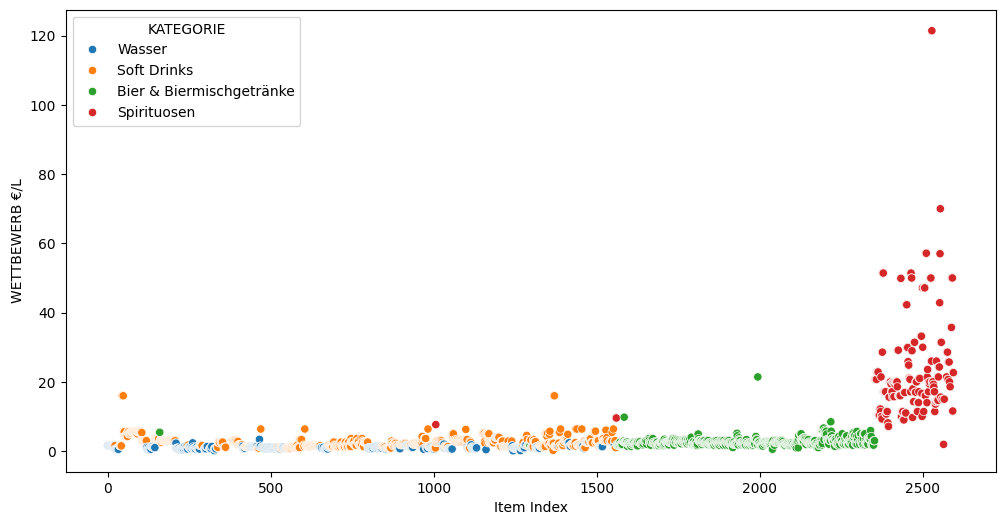

In [86]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=range(len(df)), y='LIETRPREIS_WB',data=df,hue='KATEGORIE')
plt.xlabel('Item Index')
plt.ylabel('WETTBEWERB €/L')

plt.show()

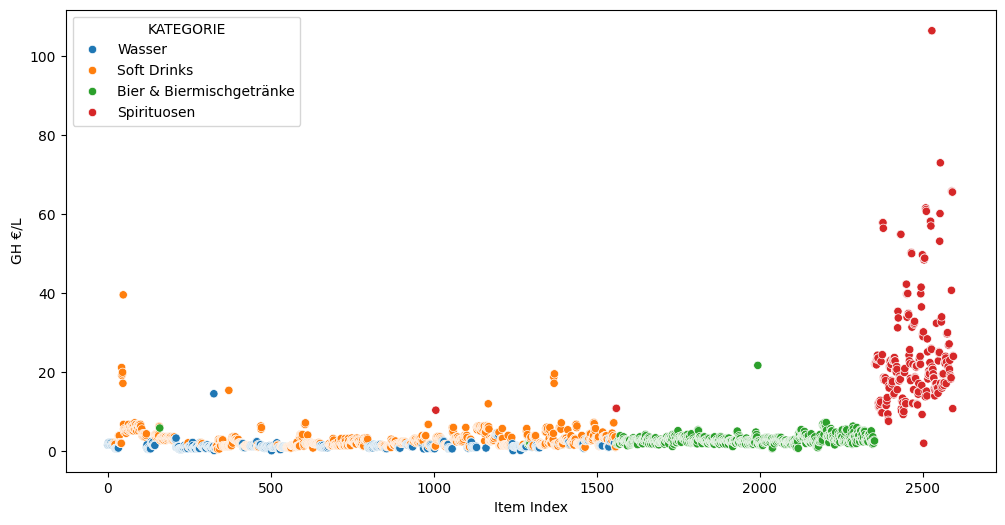

In [87]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=range(len(df)), y='LIETRPREIS_GH',data=df,hue='KATEGORIE')
plt.xlabel('Item Index')
plt.ylabel('GH €/L')

plt.show()